In [124]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

In [92]:
CUR_DIR = os.getcwd()

In [112]:
def load_model():
    # Load your .keras model
    try:
        model_path = 'captcha_crnn_model.keras'  # or full path like 'models/your_model.keras'
        model = keras.models.load_model(model_path, 
                                        custom_objects={'ctc_loss': keras.backend.ctc_batch_cost})
        
        print("[INFO] Model loaded successfully!")
        print(f"[INFO] Model architecture:")
        model.summary()
        
        
    except FileNotFoundError:
        print(f"[ERROR] Error: File '{model_path}' not found. Check the path.")
    except Exception as e:
        print(f"[ERROR] Error loading model: {str(e)}")
        
    return model

In [180]:
# Predict a CAPTCHA image
def predict_captcha(model, file_path):
    file_path = os.path.join(CUR_DIR, file_path)
    
    # print(f'[DEBUG] Current file path: {file_path}')
    
    n_samples = len(os.listdir(file_path))
    labels = []
    preds = []
    
    # print(f'[DEBUG] Number of samples: {n_samples}')

    # read from the directory
    for i, img in enumerate(os.listdir(file_path)):
        if (i == 1):
            break;
        img_read = cv2.resize(cv2.imread(os.path.join(file_path, img), 0), (300, 57))
        labels.append(img[0:-6])
        
        print('[DEBUG] Image sample and its label to be predict:')
        plt.figure(figsize=(8,8))
        plt.imshow(img_read)
        plt.title(f'{labels[0]}')
        plt.show()
        plt.close()  
    
        # # Preprocess the image
        img_reshaped = img_read.reshape(-1, 57, 300, 1)  # Reshape for model input
        print(f'[DEBUG] Image shape after preprocessing: {img_reshaped.shape}')
        
        # Predict the CAPTCHA
        print('[DEBUG] model prediction:')
        pred = model.predict(img_reshaped)


        # Step 1: Get predicted character indices (argmax)
        pred_indices = np.argmax(pred[0], axis=1)  # Shape: (259,)
        
        # Step 2: Define the character mapping (e.g., 0-25 → A-Z, 26-51 → a-z, 52-61 → 0-9)
        characters = (
            [chr(i) for i in range(ord('A'), ord('Z') + 1)] + 
            [chr(i) for i in range(ord('a'), ord('z') + 1)] + 
            [str(i) for i in range(10)] + ['_']  # Adjust based on your label set
        )
        
        # Step 3: Convert indices to characters
        pred_chars = [characters[idx] for idx in pred_indices]
        
        # Step 4: Merge and clean the sequence (remove duplicates/blanks)
        # (Assuming CTC-style decoding; modify if needed)
        final_text = []
        for i, char in enumerate(pred_chars):
            if char != '_' and (i == 0 or char != pred_chars[i - 1]):
                final_text.append(char)
        final_text = ''.join(final_text)

        preds.append(final_text)
        print(final_text)
        
    return labels, predicts

[INFO] Model loaded successfully!
[INFO] Model architecture:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 57, 300, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 57, 300, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 28, 150, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 28, 150, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 14, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 14, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 7, 37, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 259, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 259, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 259, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 259, 63)        │         4,095 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,279 (3.18 MB)

 Trainable params: 277,759 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,520 (2.12 MB)

[DEBUG] Image sample and its label to be predict:


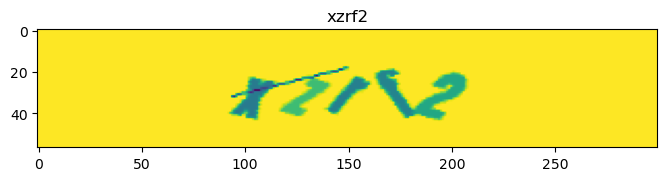

[DEBUG] Image shape after preprocessing: (1, 57, 300, 1)
[DEBUG] model prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
o


In [182]:
if __name__ == '__main__':
    # print(f'[DEBUG]{os.getcwd()}')
    model = load_model()
    labels, predicts = predict_captcha(model, "data/test")